In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import numpy as np
import pyarrow
import pandas as pd
import seaborn as sns

In [3]:
combined_df = pd.read_parquet('/Users/paigeblackstone/Desktop/Portfolio29/Portfolio29/Investment_Management/datapull_YF_082824/congress_stock_data.parquet')
combined_df.columns.to_list()

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Industry',
 'Sector',
 'Market Cap',
 'PE Ratio',
 'Price to Book',
 'Return on Equity',
 'Price to Sales',
 'Dividend Yield',
 'Current Ratio',
 'Beta',
 'Address1',
 'City',
 'State',
 'Zip',
 'Country',
 'Phone',
 'Website',
 'Industry Key',
 'Industry Disp',
 'Sector Key',
 'Sector Disp',
 'Long Business Summary',
 'Full Time Employees',
 'Company Officers',
 'Audit Risk',
 'Board Risk',
 'Compensation Risk',
 'Shareholder Rights Risk',
 'Overall Risk',
 'Governance Epoch Date',
 'Compensation As Of Epoch Date',
 'IR Website',
 'Max Age',
 'Price Hint',
 'Previous Close',
 'Open.1',
 'Day Low',
 'Day High',
 'Regular Market Previous Close',
 'Regular Market Open',
 'Regular Market Day Low',
 'Regular Market Day High',
 'Dividend Rate',
 'Ex Dividend Date',
 'Payout Ratio',
 'Five Year Avg Dividend Yield',
 'Forward PE',
 'Volume.1',
 'Regular Market Volume',
 'Average Volume',
 'Average Volume 10 Days',
 'Bid',
 '

calculating the difference between open and close by ticker by month of data

In [11]:
combined_df['open_close_diff'] = ((combined_df['Close'] - combined_df['Open']) / combined_df['Open']) * 100

calculating month over month percent change of trading volume by ticker

In [12]:
combined_df = combined_df.sort_values(by=['Ticker', 'Date'])
combined_df['volume_mom_change'] = combined_df.groupby('Ticker')['Volume'].pct_change() * 100

calculating month over month change in close price by ticker

In [14]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'], utc=True)
combined_df = combined_df.sort_values(by=['Ticker', 'Date'])
combined_df.set_index('Date', inplace=True)
monthly_close = combined_df.groupby('Ticker').resample('M').agg({'Close': 'last'})
monthly_close.reset_index(inplace=True)
monthly_close['monthly_return'] = monthly_close.groupby('Ticker')['Close'].pct_change() * 100


In [16]:
combined_df = pd.merge(combined_df.reset_index(), monthly_close[['Ticker', 'Date', 'monthly_return']], on=['Ticker', 'Date'], how='left')


In [17]:
print(combined_df.head())

   index                      Date        Open        High         Low  \
0      0 2020-01-31 00:00:00+00:00  216.773911  223.873828  200.863791   
1      1 2020-02-29 00:00:00+00:00  207.110925  219.244956  181.605603   
2      2 2020-03-30 23:00:00+00:00  165.829335  197.213635  137.178695   
3      3 2020-04-29 23:00:00+00:00  176.624813  209.125851  150.532978   
4      4 2020-05-30 23:00:00+00:00  215.125735  240.377989  198.568780   

        Close   Volume   Ticker                        Industry  \
0  216.249698  1707831  0QZI.IL  Internet Content & Information   
1  207.606898   917405  0QZI.IL  Internet Content & Information   
2  165.552751  1514934  0QZI.IL  Internet Content & Information   
3  176.314108  1279808  0QZI.IL  Internet Content & Information   
4  216.181845   753312  0QZI.IL  Internet Content & Information   

                   Sector  ...  Price to Book  Return on Equity  \
0  Communication Services  ...       9.186446           0.22275   
1  Communication S

examining valuation - 
-high PE ratio indicates overvaluation or genuinely strong growth prospects, low indicates undervaluation or growth challenges. represents share price divided by earnings per share
-price to book ratio above 1 indicates overvaluation or strong growth prospects. below 1 indicates possible undervaluation, or market trending towards declined value. represents market value per share by book value (asserts minus liabilities)
-high price to sale ratio indicates possible overvaluation or the market trending towards future growth. low price to sale ratio indicates undervaluation, or that the company is generating stronger growth relative to market value. represents market cap divided by the last 12 months of revenue, to measure how much investors are paying for each dollar of sales


Analysis of stock performance metrics using the monthly cash flow data. in cases where the month has null values for certain statistics, the row will be populated with the median value of the metric for that year of data fora  given ticker. 

In [19]:
combined_df['Year'] = combined_df['Date'].dt.year
median_by_year_ticker = combined_df.groupby(['Ticker', 'Year'])[['PE Ratio', 'Price to Book', 'Price to Sales']].median().reset_index()

In [20]:
combined_df = pd.merge(combined_df, median_by_year_ticker, on=['Ticker', 'Year'], suffixes=('', '_Median'))


In [21]:
pe_ratio_map = median_by_year_ticker.set_index(['Ticker', 'Year'])['PE Ratio']
price_to_book_map = median_by_year_ticker.set_index(['Ticker', 'Year'])['Price to Book']
price_to_sales_map = median_by_year_ticker.set_index(['Ticker', 'Year'])['Price to Sales']

In [22]:
combined_df['PE Ratio'] = combined_df.apply(
    lambda row: pe_ratio_map.loc[(row['Ticker'], row['Year'])] if pd.isna(row['PE Ratio']) else row['PE Ratio'],
    axis=1
)

combined_df['Price to Book'] = combined_df.apply(
    lambda row: price_to_book_map.loc[(row['Ticker'], row['Year'])] if pd.isna(row['Price to Book']) else row['Price to Book'],
    axis=1
)

combined_df['Price to Sales'] = combined_df.apply(
    lambda row: price_to_sales_map.loc[(row['Ticker'], row['Year'])] if pd.isna(row['Price to Sales']) else row['Price to Sales'],
    axis=1
)

In [23]:
combined_df.drop(columns=['Year'], inplace=True)

descriptive stats for valuation before and after removing outliers using the IQR method - focusing on the middle 50% of the data. this will clean up our mean and standard deviation

In [24]:
cleaned_stats = combined_df[['PE Ratio', 'Price to Book', 'Price to Sales']].describe()


In [25]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

combined_df = remove_outliers(combined_df, 'PE Ratio')
combined_df = remove_outliers(combined_df, 'Price to Book')
combined_df = remove_outliers(combined_df, 'Price to Sales')

In [26]:
cleaned_stats = combined_df[['PE Ratio', 'Price to Book', 'Price to Sales']].describe()
cleaned_stats

,PE Ratio,Price to Book,Price to Sales
count,74738.000000,74738.000000,74738.000000
mean,19.652161,2.216850,1.863538
std,11.381990,1.959487,1.618623
min,0.091522,0.000128,0.000101
25%,11.187969,0.868323,0.554925
50%,17.086956,1.662061,1.431799
75%,25.509027,3.060080,2.844729
max,60.344020,8.672224,6.995191


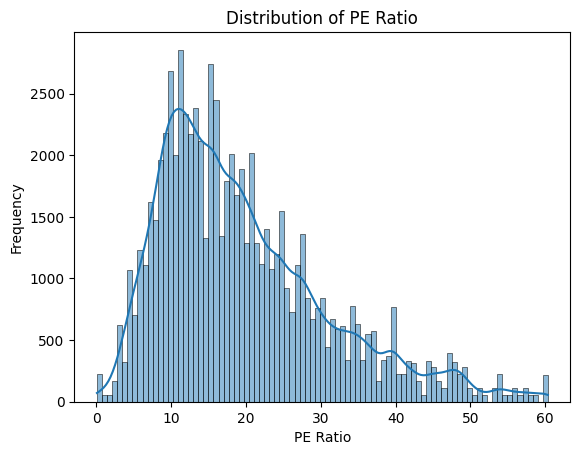

In [27]:
sns.histplot(combined_df['PE Ratio'].dropna(), kde=True)
plt.title('Distribution of PE Ratio')
plt.xlabel('PE Ratio')
plt.ylabel('Frequency')
plt.show()

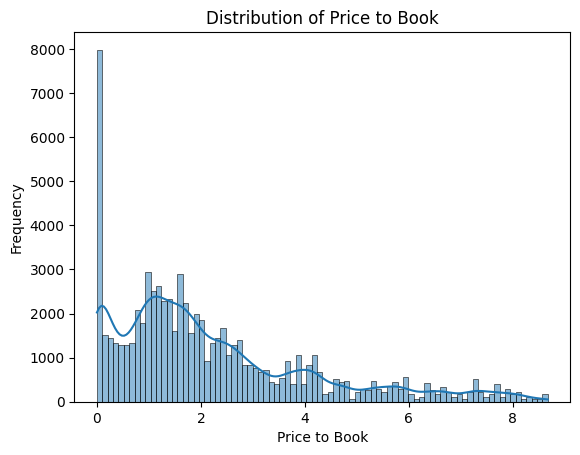

In [28]:
sns.histplot(combined_df['Price to Book'].dropna(), kde=True)
plt.title('Distribution of Price to Book')
plt.xlabel('Price to Book')
plt.ylabel('Frequency')
plt.show()

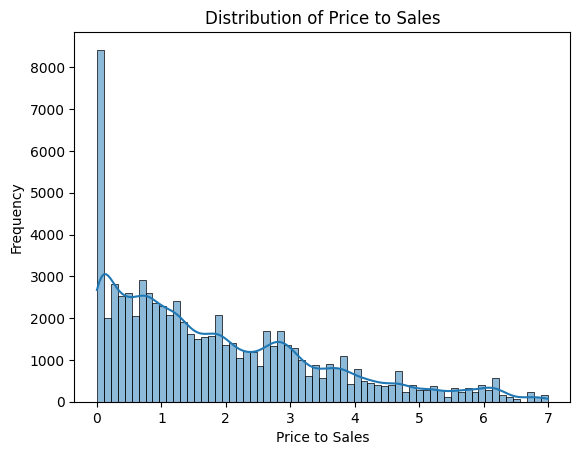

In [29]:
sns.histplot(combined_df['Price to Sales'].dropna(), kde=True)
plt.title('Distribution of Price to Sales')
plt.xlabel('Price to Sales')
plt.ylabel('Frequency')
plt.show()

In [30]:
valuation_metrics = ['PE Ratio', 'Price to Book', 'Price to Sales']

In [31]:
industry_median = combined_df.groupby('Industry')[valuation_metrics].median().reset_index()
industry_median.columns = ['Industry', 'Median_PE', 'Median_PB', 'Median_PS']
combined_df = combined_df.merge(industry_median, on='Industry', how='left')


calculating deviation from the industry median for all valuation ratios 

In [32]:
combined_df['PE_Deviation'] = combined_df['PE Ratio'] - combined_df['Median_PE']
combined_df['PB_Deviation'] = combined_df['Price to Book'] - combined_df['Median_PB']
combined_df['PS_Deviation'] = combined_df['Price to Sales'] - combined_df['Median_PS']

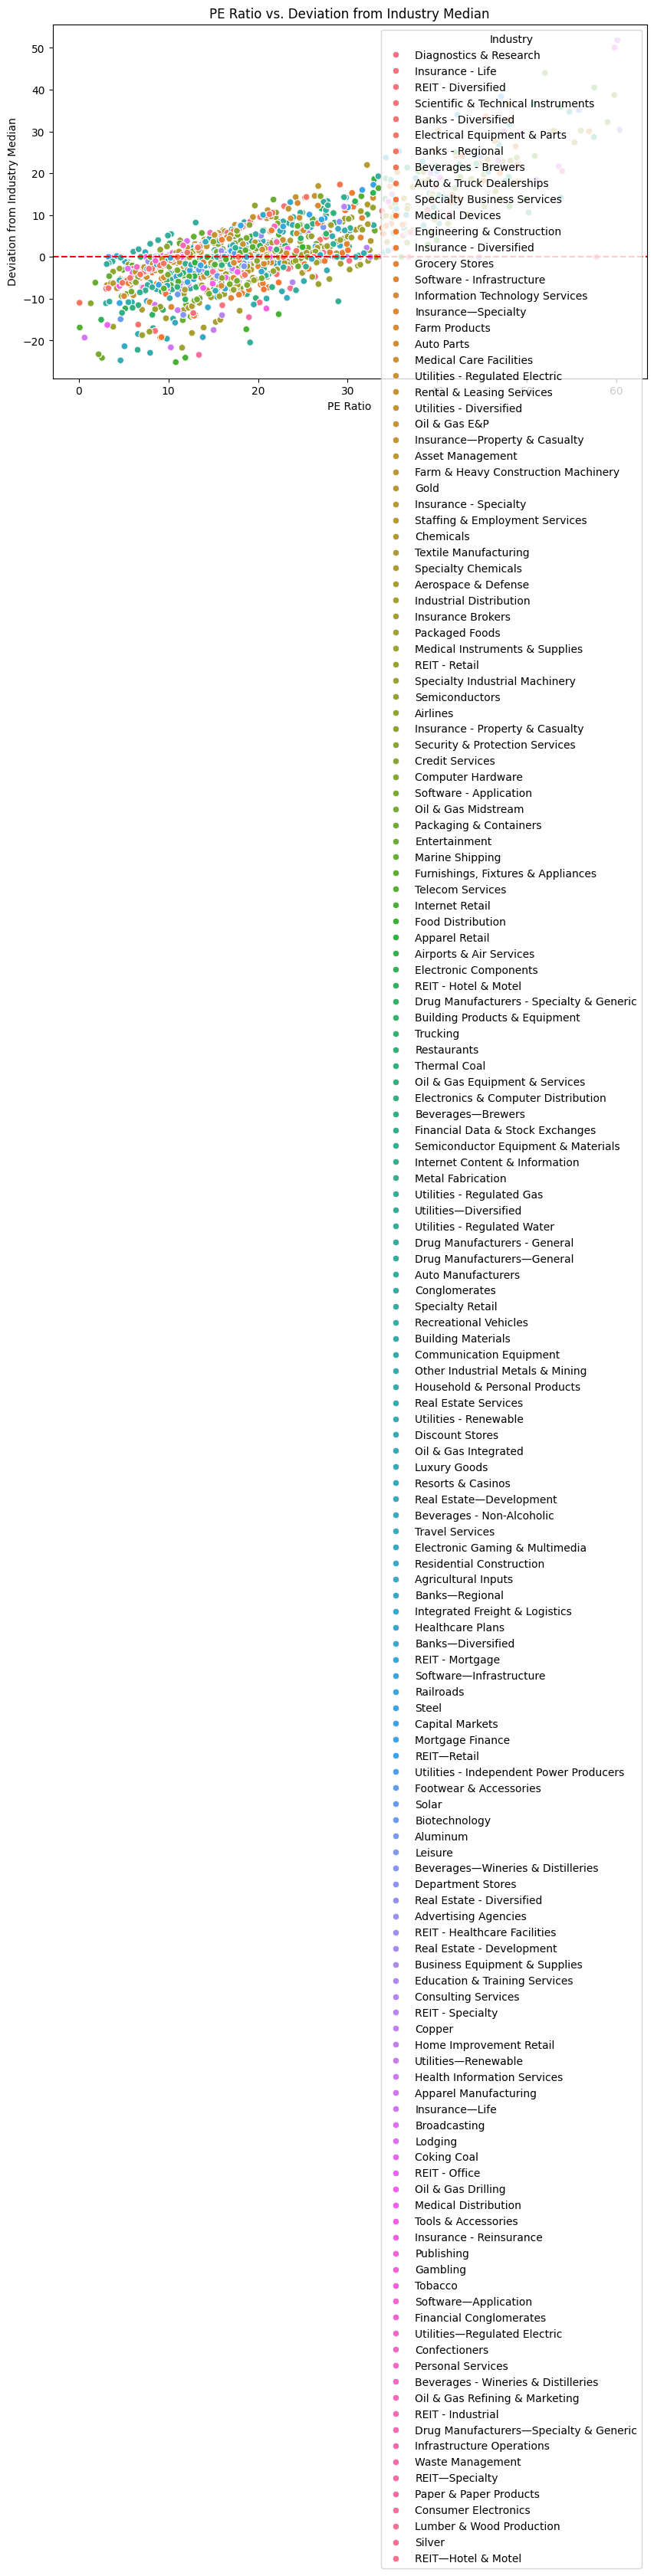

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PE Ratio', y='PE_Deviation', hue='Industry', data=combined_df)
plt.axhline(0, color='red', linestyle='--')
plt.title('PE Ratio vs. Deviation from Industry Median')
plt.xlabel('PE Ratio')
plt.ylabel('Deviation from Industry Median')
plt.show()

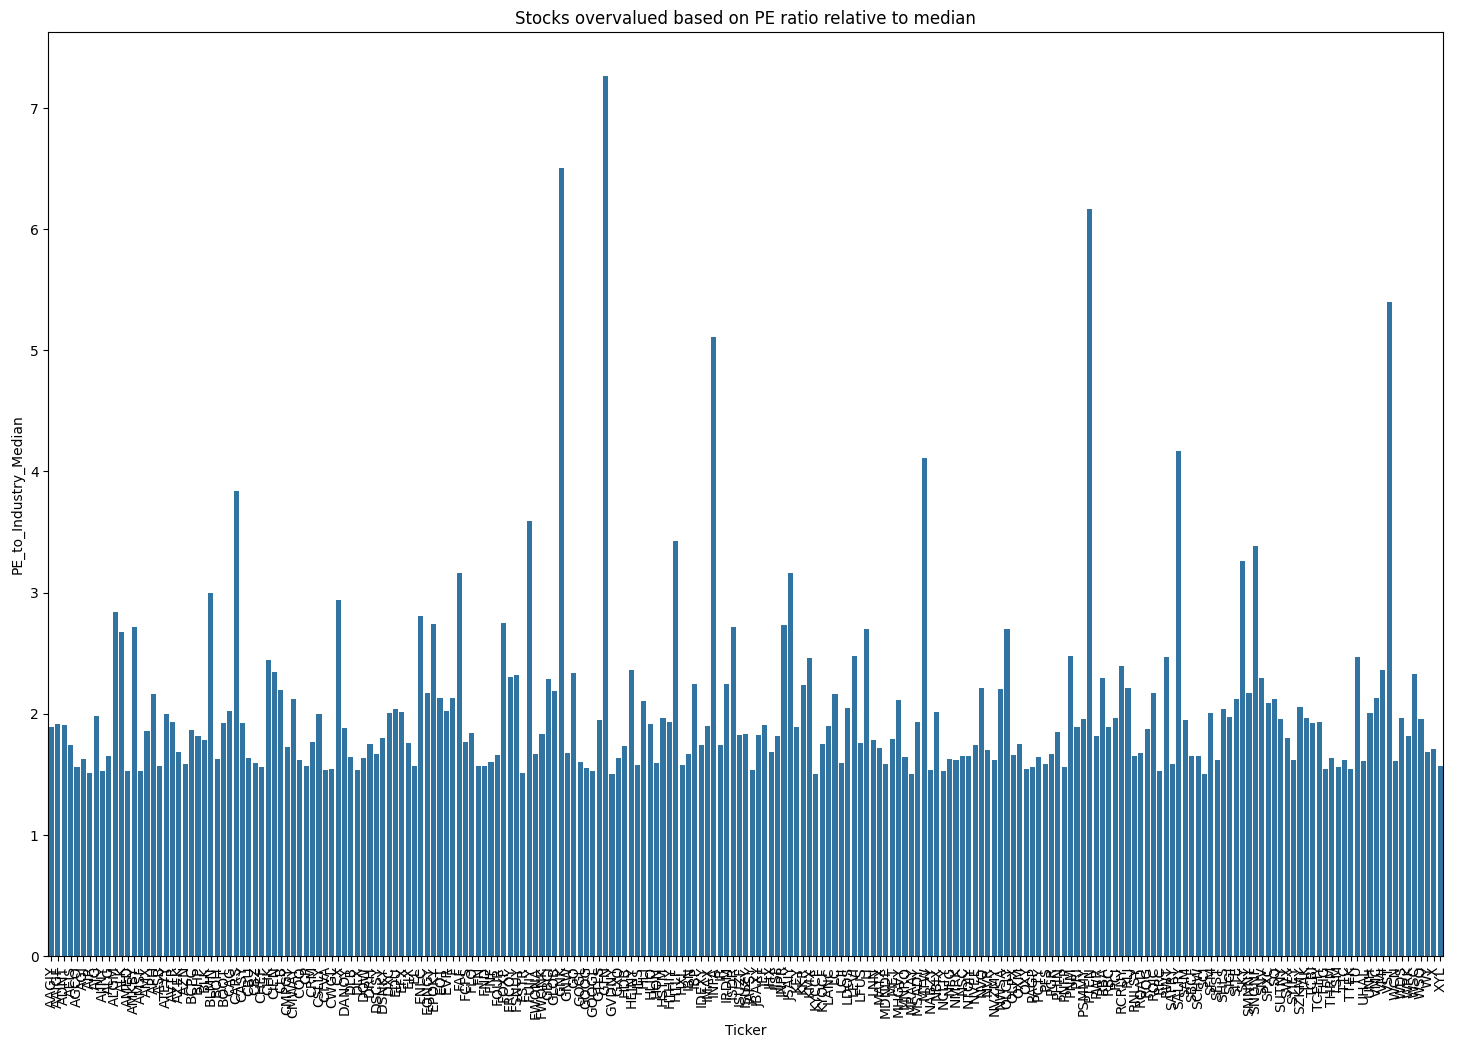

In [34]:
combined_df['PE_to_Industry_Median'] = combined_df['PE Ratio'] / combined_df['Median_PE']

#filter stocks with high PE compared to industry median 
overvalued_stocks = combined_df[combined_df['PE_to_Industry_Median'] > 1.5]

plt.figure(figsize=(18, 12))
sns.barplot(x='Ticker', y='PE_to_Industry_Median', data=overvalued_stocks)
plt.xticks(rotation=90)
plt.title('Stocks overvalued based on PE ratio relative to median')
plt.show()

examining valuation - (market approach)
discounted cash flow model will be used to assess valuation by ticker. we estimate future cash flows and normalize them to the present value with a discount rate. doing so compares the intrinsic value of an investment in a ticker to the current market price. intrinsic value repesents the stock's true value with respect to risks and changes. a low intrinsic value relative to current price could represent a good buying opportunity. if the intrinsic value is higher than the current price, it could be an indication to sell due to overvaluation. 

free cash flow = earnings before interest after taxes + depreciation&amortization - capital expenditures - net working capital

expected rate of return on equity = capm, measures sensitivity to market returns, risk free rate and equity risk premium
cost of equity = beta * equity risk premium + risk free rate



In [35]:
combined_df.columns.to_list()

['index',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Industry',
 'Sector',
 'Market Cap',
 'PE Ratio',
 'Price to Book',
 'Return on Equity',
 'Price to Sales',
 'Dividend Yield',
 'Current Ratio',
 'Beta',
 'open_close_diff',
 'volume_mom_change',
 'monthly_return_x',
 'monthly_return_y',
 'PE Ratio_Median',
 'Price to Book_Median',
 'Price to Sales_Median',
 'Median_PE',
 'Median_PB',
 'Median_PS',
 'PE_Deviation',
 'PB_Deviation',
 'PS_Deviation',
 'PE_to_Industry_Median']

In [36]:
import yfinance as yf
import pandas as pd

tickers = combined_df['Ticker'].unique()
all_dataframes = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    cashflow = stock.cashflow

    if not cashflow.empty:
        #transpose the DataFrame so dates become rows instead of columns
        cashflow = cashflow.T

        cashflow = cashflow.reset_index()

        cashflow.rename(columns={'index': 'Date'}, inplace=True)

        cashflow['Date'] = pd.to_datetime(cashflow['Date'])

        cashflow['Month_Year'] = cashflow['Date'].dt.strftime('%Y-%m')

        cashflow['Ticker'] = ticker

        all_dataframes.append(cashflow)
    else:
        print(f"No cash flow data available for {ticker}")

combined_cashflow_df = pd.concat(all_dataframes, ignore_index=True)

print(combined_cashflow_df.head())



        Date Free Cash Flow Repurchase Of Capital Stock Repayment Of Debt  \
0 2023-10-31   1474000000.0                -575000000.0               0.0   
1 2022-10-31   1021000000.0               -1139000000.0      -609000000.0   
2 2021-10-31   1297000000.0                -788000000.0      -417000000.0   
3 2020-10-31    802000000.0                -469000000.0     -1762000000.0   
4 2019-10-31            NaN                         NaN               NaN   

  Issuance Of Debt Capital Expenditure Interest Paid Supplemental Data  \
0              0.0        -298000000.0                      89000000.0   
1      600000000.0        -291000000.0                      85000000.0   
2      848000000.0        -188000000.0                      76000000.0   
3     1717000000.0        -119000000.0                      71000000.0   
4              NaN                 NaN                             NaN   

  Income Tax Paid Supplemental Data End Cash Position Beginning Cash Position  \
0          

In [37]:
output_path = "/Users/paigeblackstone/Desktop/Portfolio29/Portfolio29/Investment_Management/datapull_YF_081224/combined_cashflow_data.parquet"

combined_cashflow_df.columns = [str(col) for col in combined_cashflow_df.columns]

combined_cashflow_df.to_parquet(output_path, index=False)

In [38]:
nan_percentage = combined_cashflow_df.isna().mean() * 100

In [39]:
columns_to_drop = nan_percentage[nan_percentage > 50].index

# Drop these columns from the DataFrame
combined_cashflow_df_cleaned = combined_cashflow_df.drop(columns=columns_to_drop)

In [31]:
combined_cashflow_df_cleaned.dtypes

Date                                              datetime64[ns]
Free Cash Flow                                            object
Repurchase Of Capital Stock                               object
Repayment Of Debt                                         object
Issuance Of Debt                                          object
Capital Expenditure                                       object
End Cash Position                                         object
Beginning Cash Position                                   object
Effect Of Exchange Rate Changes                           object
Changes In Cash                                           object
Financing Cash Flow                                       object
Cash Flow From Continuing Financing Activities            object
Net Other Financing Charges                               object
Cash Dividends Paid                                       object
Common Stock Dividend Paid                                object
Net Common Stock Issuance

In [40]:
combined_cashflow_df_cleaned.to_parquet('/Users/paigeblackstone/Desktop/Portfolio29/Portfolio29/Investment_Management/datapull_YF_081224/cashflow_data.parquet')

calculating the market rate of return to use as a benchmark - using s&p500

In [41]:
import yfinance as yf
import pandas as pd

sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-01-01', interval='1mo')

sp500['SP500_Return'] = sp500['Adj Close'].pct_change()

sp500['Month_Year'] = sp500.index.to_period('M').astype(str)
combined_cashflow_df_cleaned = combined_cashflow_df_cleaned.merge(sp500[['Month_Year', 'SP500_Return']], on='Month_Year', how='left')


[*********************100%%**********************]  1 of 1 completed


In [40]:
#combined_cashflow_df_cleaned = combined_cashflow_df_cleaned.drop(columns=['SP500_Return_x'])
#combined_cashflow_df_cleaned = combined_cashflow_df_cleaned.rename(columns={'SP500_Return_y': 'SP500_Return'})

# Verify that the column has been dropped
#print(combined_cashflow_df_cleaned.head())


        Date Free Cash Flow Repurchase Of Capital Stock Repayment Of Debt  \
0 2023-10-31   1474000000.0                -575000000.0               0.0   
1 2022-10-31   1021000000.0               -1139000000.0      -609000000.0   
2 2021-10-31   1297000000.0                -788000000.0      -417000000.0   
3 2020-10-31    802000000.0                -469000000.0     -1762000000.0   
4 2019-10-31            NaN                         NaN               NaN   

  Issuance Of Debt Capital Expenditure End Cash Position  \
0              0.0        -298000000.0      1593000000.0   
1      600000000.0        -291000000.0      1056000000.0   
2      848000000.0        -188000000.0      1490000000.0   
3     1717000000.0        -119000000.0      1447000000.0   
4              NaN                 NaN               NaN   

  Beginning Cash Position Effect Of Exchange Rate Changes Changes In Cash  \
0            1056000000.0                       5000000.0     532000000.0   
1            149000000

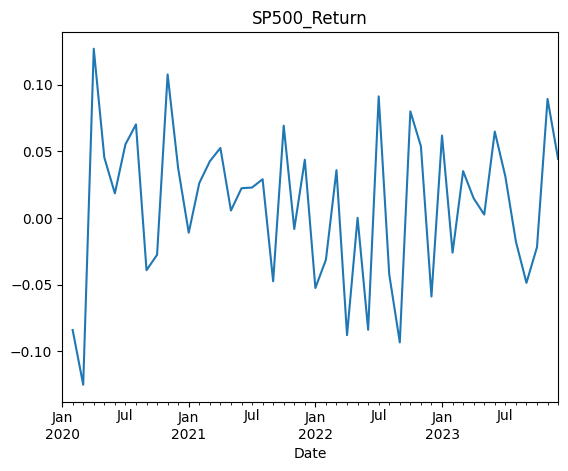

In [42]:
sp500['SP500_Return'].plot(title='SP500_Return')
plt.show()

In [43]:
combined_df['Month_Year'] = combined_df['Date'].dt.strftime('%Y-%m')
combined_df = combined_df.sort_values(by=['Ticker', 'Month_Year'])

#monthly rate of return by Ticker and Month_Year
combined_df['Monthly_Return'] = combined_df.groupby('Ticker')['Close'].pct_change()
print(combined_df[['Ticker', 'Month_Year', 'Close', 'Monthly_Return']].head(20))


   Ticker Month_Year       Close  Monthly_Return
0       A    2020-01   84.496690             NaN
1       A    2020-02   80.407056       -0.048400
2       A    2020-03   69.427349       -0.136552
3       A    2020-04   73.591760        0.059982
4       A    2020-05   79.035872        0.073977
5       A    2020-06   85.996057        0.088064
6       A    2020-07   90.569127        0.053178
7       A    2020-08   95.612152        0.055681
8       A    2020-09   96.416586        0.008414
9       A    2020-10  101.709056        0.054892
10      A    2020-11  108.004437        0.061896
11      A    2020-12  114.194668        0.057315
12      A    2021-01  121.808175        0.066671
13      A    2021-02  121.828759        0.000169
14      A    2021-03  119.177866       -0.021759
15      A    2021-04  130.168028        0.092216
16      A    2021-05  129.526944       -0.004925
17      A    2021-06  140.384378        0.083824
18      A    2021-07  146.822704        0.045862
19      A    2021-08

In [44]:
group_sizes = combined_df.groupby(['Ticker', 'Month_Year']).size()
print(group_sizes[group_sizes < 2])

Ticker  Month_Year
A       2020-01       1
        2020-02       1
        2020-03       1
        2020-04       1
        2020-05       1
                     ..
ZURVY   2024-04       1
        2024-05       1
        2024-06       1
        2024-07       1
        2024-08       1
Length: 74738, dtype: int64


In [45]:
def calculate_sharpe_ratio(df):
    if df['Excess_Return'].isnull().all() or len(df) < 2:
        return pd.Series({'Sharpe_Ratio': None})
    
    mean_excess_return = df['Excess_Return'].mean()
    std_excess_return = df['Excess_Return'].std()
    
    if std_excess_return == 0:
        return pd.Series({'Sharpe_Ratio': None})
    
    return pd.Series({'Sharpe_Ratio': mean_excess_return / std_excess_return})

In [46]:
#risk-free rate 3-month U.S. Treasury bill rate
risk_free_rate = 0.01 / 12  #assuming annual risk-free rate of 1%, converted to monthly
combined_df['Excess_Return'] = combined_df['Monthly_Return'] - risk_free_rate
sharpe_ratios = combined_df.groupby(['Ticker']).apply(
    lambda x: calculate_sharpe_ratio(x)
).reset_index()

print(sharpe_ratios.head())


  Ticker  Sharpe_Ratio
0      A      0.157819
1  AAGIY     -0.079036
2  AAIGF     -0.077203
3    AAT     -0.050371
4   AATC      0.148786


In [47]:
combined_df = combined_df.merge(sharpe_ratios, on=['Ticker'], how='left')
#print(combined_df[['Ticker', 'Month_Year', 'Monthly_Return', 'Sharpe_Ratio']].head(20))

In [91]:
# import gc

# del all_dataframes
# del cashflow
# del group_sizes
# del combined_cashflow_df
# del median_by_year_ticker
# del stocks_market_df
# del stocks_yf_df


In [48]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74738 entries, 0 to 74737
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  74738 non-null  int64              
 1   Date                   74738 non-null  datetime64[ns, UTC]
 2   Open                   74738 non-null  float64            
 3   High                   74738 non-null  float64            
 4   Low                    74738 non-null  float64            
 5   Close                  74738 non-null  float64            
 6   Volume                 74738 non-null  int64              
 7   Ticker                 74738 non-null  object             
 8   Industry               74682 non-null  object             
 9   Sector                 74682 non-null  object             
 10  Market Cap             74735 non-null  float64            
 11  PE Ratio               74738 non-null  float64        

In [49]:
risk_free_rate = 0.02  
combined_df['Ke'] = risk_free_rate + combined_df['Beta'] * (combined_df['Monthly_Return'] - risk_free_rate)

In [50]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)

# Inspect available info fields
print(stock.info.keys())

dict_keys(['address1', 'city', 'state', 'zip', 'country', 'phone', 'website', 'industry', 'industryKey', 'industryDisp', 'sector', 'sectorKey', 'sectorDisp', 'longBusinessSummary', 'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'irWebsite', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currenc

In [67]:
import yfinance as yf
import pandas as pd

def fetch_financial_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info
    market_cap = info.get('marketCap')
    total_debt = info.get('totalDebt')
    total_cash = info.get('totalCash')
    shares_outstanding = info.get('sharesOutstanding')
    beta = info.get('beta', None) 
    interest_expense = info.get('interestExpense', None)

    #balance_sheet = stock.quarterly_balance_sheet
    #income_statement = stock.quarterly_financials
    return pd.DataFrame({
        'Ticker': ticker,
        'Market_Cap': [market_cap],
        'Total_Debt': [total_debt],
        'Total_Cash': [total_cash],
        'Shares_Outstanding': [shares_outstanding],
        'Beta': [beta],
        'Interest_Expense': [interest_expense]
    })

tickers = combined_df['Ticker'].unique()
financial_data = pd.concat([fetch_financial_data(ticker) for ticker in tickers], ignore_index=True)

combined_df = pd.merge(combined_df, financial_data, on='Ticker', how='left')



ConnectionError: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out.

In [56]:
beta_means = combined_df.groupby('Ticker')['Beta_x'].transform('mean')
combined_df['Beta'] = combined_df['Beta_x'].fillna(beta_means)

In [57]:
risk_free_rate = 0.02  # e.g. 2%
expected_market_return = combined_df['Monthly_Return'].mean()

combined_df['Cost_of_Equity'] = risk_free_rate + combined_df['Beta_x'] * (expected_market_return - risk_free_rate)

In [60]:
combined_df['Market_Value_Equity'] = combined_df['Market Cap']
combined_df['Market_Value_Debt'] = combined_df['Total_Debt']

combined_df['Cost_of_Debt'] = 0.05  # assuming constant cost of debt

combined_df['Tax_Rate'] = 0.25  # assuming a constant tax rate

combined_df['WACC'] = (
    (combined_df['Market_Value_Equity'] / (combined_df['Market_Value_Equity'] + combined_df['Market_Value_Debt'])) * combined_df['Cost_of_Equity'] +
    (combined_df['Market_Value_Debt'] / (combined_df['Market_Value_Equity'] + combined_df['Market_Value_Debt'])) * combined_df['Cost_of_Debt'] * (1 - combined_df['Tax_Rate'])
)


In [61]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74738 entries, 0 to 74737
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  74738 non-null  int64              
 1   Date                   74738 non-null  datetime64[ns, UTC]
 2   Open                   74738 non-null  float64            
 3   High                   74738 non-null  float64            
 4   Low                    74738 non-null  float64            
 5   Close                  74738 non-null  float64            
 6   Volume                 74738 non-null  int64              
 7   Ticker                 74738 non-null  object             
 8   Industry               74682 non-null  object             
 9   Sector                 74682 non-null  object             
 10  Market Cap             74735 non-null  float64            
 11  PE Ratio               74738 non-null  float64        

In [62]:
import yfinance as yf
import pandas as pd

def fetch_cash_flow_data(ticker):
    stock = yf.Ticker(ticker)
    cash_flow = stock.cashflow
    
    if 'Free Cash Flow' in cash_flow.index:
        fcf = cash_flow.loc['Free Cash Flow']
        fcf_df = fcf.reset_index()
        fcf_df.columns = ['Date', 'Free_Cash_Flow']
        fcf_df['Ticker'] = ticker
        fcf_df['Date'] = pd.to_datetime(fcf_df['Date'])
        return fcf_df
    else:
        return pd.DataFrame(columns=['Date', 'Free_Cash_Flow', 'Ticker'])

tickers = combined_df['Ticker'].unique()
fcf_data = pd.concat([fetch_cash_flow_data(ticker) for ticker in tickers], ignore_index=True)

fcf_data['Month_Year'] = fcf_data['Date'].dt.to_period('M').astype(str)

combined_df = pd.merge(combined_df, fcf_data[['Ticker', 'Month_Year', 'Free_Cash_Flow']], on=['Ticker', 'Month_Year'], how='left')


In [63]:
combined_df['Discount_Factor'] = 1 / (1 + combined_df['WACC']) ** (combined_df['Date'].dt.year - combined_df['Date'].dt.year.min())
combined_df['PV_Free_Cash_Flow'] = combined_df['Free_Cash_Flow'] * combined_df['Discount_Factor']

In [64]:
perpetual_growth_rate = 0.03
combined_df['Terminal_Value'] = (combined_df['Free_Cash_Flow'] * (1 + perpetual_growth_rate)) / (combined_df['WACC'] - perpetual_growth_rate)
combined_df['Terminal_Value'] = combined_df['Terminal_Value'].replace([np.inf, -np.inf], np.nan)
combined_df['Terminal_Value'] = combined_df['Terminal_Value'].fillna(0)

In [65]:
last_month_df = combined_df.groupby('Ticker').apply(lambda x: x[x['Date'] == x['Date'].max()]).reset_index(drop=True)
last_month_df['Terminal_Value'] = (last_month_df['Free_Cash_Flow'] * (1 + perpetual_growth_rate)) / (last_month_df['WACC'] - perpetual_growth_rate)
combined_df = combined_df.merge(last_month_df[['Ticker', 'Month_Year', 'Terminal_Value']], on=['Ticker', 'Month_Year'], how='left')

In [66]:
combined_df['Period'] = combined_df.groupby('Ticker').cumcount() + 1

combined_df['PV_TV'] = combined_df['Terminal_Value_x'] / np.power((1 + combined_df['WACC']), combined_df['Period'])

combined_df['PV_TV'] = combined_df['PV_TV'].replace([np.inf, -np.inf], np.nan)
combined_df['PV_TV'] = combined_df['PV_TV'].fillna(0)

combined_df['PV_TV'] = combined_df['Terminal_Value_x'] / np.power((1 + combined_df['WACC']), combined_df['Period'])

print(combined_df[['Ticker', 'Date', 'Terminal_Value_x', 'WACC', 'Period', 'PV_TV']].head())

  Ticker                      Date  Terminal_Value_x      WACC  Period PV_TV
0      A 2020-01-31 05:00:00+00:00               0.0  0.011749       1   0.0
1      A 2020-02-29 05:00:00+00:00               0.0  0.011749       2   0.0
2      A 2020-03-31 04:00:00+00:00               0.0  0.011749       3   0.0
3      A 2020-04-30 04:00:00+00:00               0.0  0.011749       4   0.0
4      A 2020-05-31 04:00:00+00:00               0.0  0.011749       5   0.0


In [ ]:
combined_df['Ent_Value'] = combined_df['PV_Free_Cash_Flow'] + combined_df['PV_TV']

combined_df['Eq_Value_fcf'] = combined_df['Ent_Value'] - combined_df['Total_Debt'] + combined_df['Total_Cash']

combined_df['ImpliedSharePrice_mkt'] = combined_df['Market_Value_Equity'] / combined_df['OutShares']

combined_df['ImpliedSharePrice_fcf'] = combined_df['Eq_Value_fcf'] / combined_df['OutShares']

print(combined_df[['Ticker', 'Month_Year', 'Ent_Value', 'Market_Value_Equity', 'Eq_Value_fcf', 'ImpliedSharePrice_mkt', 'ImpliedSharePrice_fcf']].head())

examining profitability (income approach)
- high return on equity indicates effective conversion of investments to profits. a more important thing to look at is consistent steady increases to ensyre the company is running a strong and profitable business.return on equity represents income divided by shareholder equity to show effiency of a company's operations to generate profit. 
- dividend yields can indicate higher return of profit to shareholders, but an unusually high dividend yield could be related to sharp dips in stock price, indicating underlying issues 

examining liquidity and solvency (asset-based approach)
- current ratio represents current assets over current liabilities, measuring a company's ability to cover short term liablities
- current ratio above 1 indicates a company has more assets than liablities, therefore financial stability. if it is excessively high, the company may not be using its assets effectively
- usually industry/sector specific

larger question - are government employee investors responding to the market, or is the market responding to the driving force of government employee investments?

is buy/sell recommendation a predictor of congress/senate buys and sells? or is congress/senate buys and sells a predictor of a larger market movement 

does this expand beyond the buy sell recommendations from DCF, etc.? are fundamentals better predictors than buy sell recommendation methods? how much of an impact do swings in congress/senate transactions' fundamentals have on the magnitude of a responding swing in the overall market?

In [ ]:
def risk_return(df, adj=True, crypto=False):
    if adj:
        close=df.loc[:, "adj_close"].copy()
    else:
        close=df.loc[:, "close"].copy()
    if crypto:
        trading_days=365
    else: 
        trading_days=252
    
    stock_returns=close.pct_change().dropna().mul(100)
    summary=stock_returns.describe().T.loc[:, ["mean", "std"]]
    summary["mean"]=summary["mean"]*trading_days
    summary["std"]=summary["std"]*np.sqrt(trading_days)
    summary.rename(columns={'mean':'Return', 'std': 'Risk'}, inplace=True)
    fig=px.scatter(summary,
                   x='Risk',
                   y='Return',
                   title='monthly risk/return',
                   text=summary.index,
                   template='plotly_dark')
    fig.update_traces(marker={'size':12},
                      textposition='top center')
    fig.update_layout(
        legend=dict(title=None),
        title={
            'y':0.9,
            'x':0.5,
            'font':{'size':20},
            'xanchor':'center',
            'yanchor':'top'
        },
        xaxis=dict(title=dict(font=dict(size=14))),
        yaxis=dict(title=dict(font=dict(size=14)))
    )
    fig.show()


In [ ]:
def return_corr(df, adj=True, crypto=False):
    if adj:
        close=df.loc[:, "adj_close"].copy()
    else:
        close=df.loc[:, "close"].copy()
    
    if crypto:
        trading_days=365
    else:
        trading_days=252
    
    stock_return=close.pct_change().dropna().mul(100)
    
    summary=stock_return.describe().T.loc[:, ["mean", "std"]]
    summary["mean"]=summary["mean"]*trading_days
    summary["std"]=summary["std"]*np.sqrt(trading_days)
    summary.rename(columns={'mean':'Return', 'std': 'Risk'}, inplace=True)
    
    fig=px.imshow(stock_return.corr(), text_auto=True, color_continuous_scale='tempo', template='plotly_dark', title="correlation of returns")
    fig.update_layout(
        legend=dict(title=None),
        title={
            'y':0.9,
            'x':0.5,
            'font':{'size':20},
            'xanchor':'center',
            'yanchor':'top'
        })
    fig.show()